# Creating a data-backed playing field
Felix Zaussinger | 30.10.2020

## Core Analysis Goal(s)

1. Find LULC GIS layer and download data.
2. Downsampling to ~ 3 lower resolutions/larger cellsizes via rasterio.

## Key Insight(s)

1. The Historical and present land use dataset (downloaded 30.11.2020 at https://hlamap.org.uk/) useful for our purposes.

## Arising Todo(s)

1. Find forest inventory data and merge with HLA data to get the full picture.

#### Package imports

In [ ]:
import os
import sys
import logging

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import geopandas as gpd
import rasterio as rio

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

#### Directory settings

In [2]:
data_raw = os.path.join("..", "data", "raw")
data_processed = os.path.join("..", "data", "processed")
figure_dir = os.path.join("..", "plots")

#### Define dimensions of output maps

In [3]:
# raster dims
rows = cols = 90

#### Whether optional, time-intensive tasks should be run

In [4]:
run_time_intensive_task = False

Promising data sources for GIS layers are summarised here: https://www.environment.gov.scot/maps/other-map-tools/#land.

These look really cool:

- HabMoS EUNIS Land Cover Scotland (https://map.environment.gov.scot/sewebmap/?layers=eunisLandCoverScotland&extent=-787366,74257,1322365,1708636)
- EUNIS Combined Map (https://hub.jncc.gov.uk/assets/2048c042-5d68-46c6-8021-31d177b00ac4)
- Benchmark LULC data set ( not for free :( ): https://www.ceh.ac.uk/services/land-cover-map-2015
- National Biodiversity Network: https://records.nbnatlas.org/explore/your-area#52.9548|1.1580999999999904|12|ALL_SPECIES
- [USED] Historical and present land use (downloaded 30.11.2020): https://hlamap.org.uk/
- Forest inventory and grant eligibility data: https://open-data-scottishforestry.hub.arcgis.com/search?collection=Dataset
- [USED] Biosphere Reserves: https://gateway.snh.gov.uk/natural-spaces/dataset.jsp?dsid=BIOSPH
- Geodata in general: https://www.spatialdata.gov.scot/geonetwork/srv/eng/catalog.search#/home
- [USED] National Forest Inventory (NFI): https://data-forestry.opendata.arcgis.com/datasets/b71da2b45dde4d0595b6270a87f67ea9_0

### Dataset 0: Delination of Galloway and Southern Ayrshire Biosphere Reserve

In [5]:
parks_fpath = os.path.join(data_raw, "BIOSPH_SCOTLAND_ESRI", "BIOSPH_SCOTLAND.shp")
parks = gpd.read_file(parks_fpath)

In [6]:
parks.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°45'N to 61°N, 9°W to 2°E
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

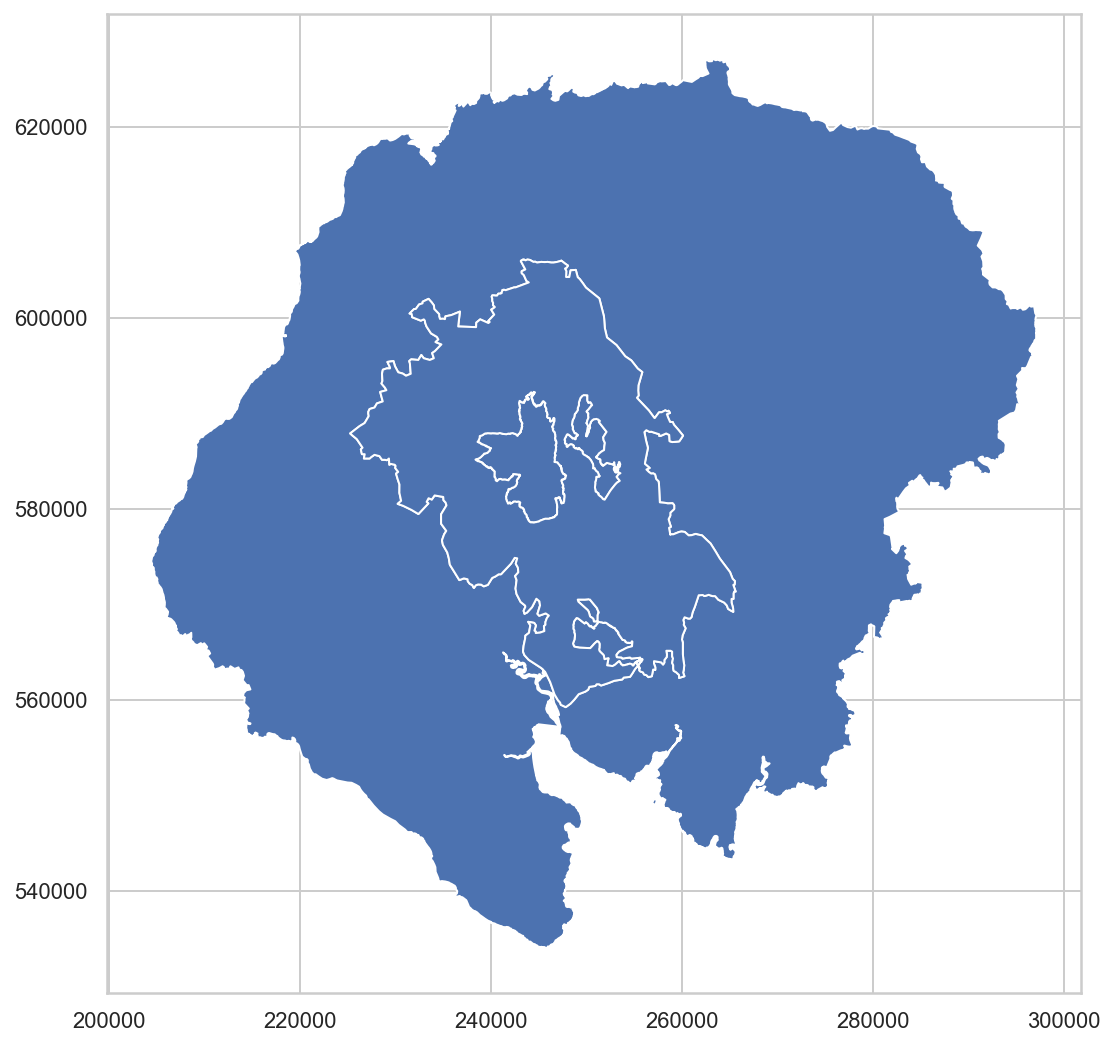

In [7]:
our_park = parks.loc[parks.NAME == parks.NAME.unique()[0]]
our_park.plot()

<AxesSubplot:>

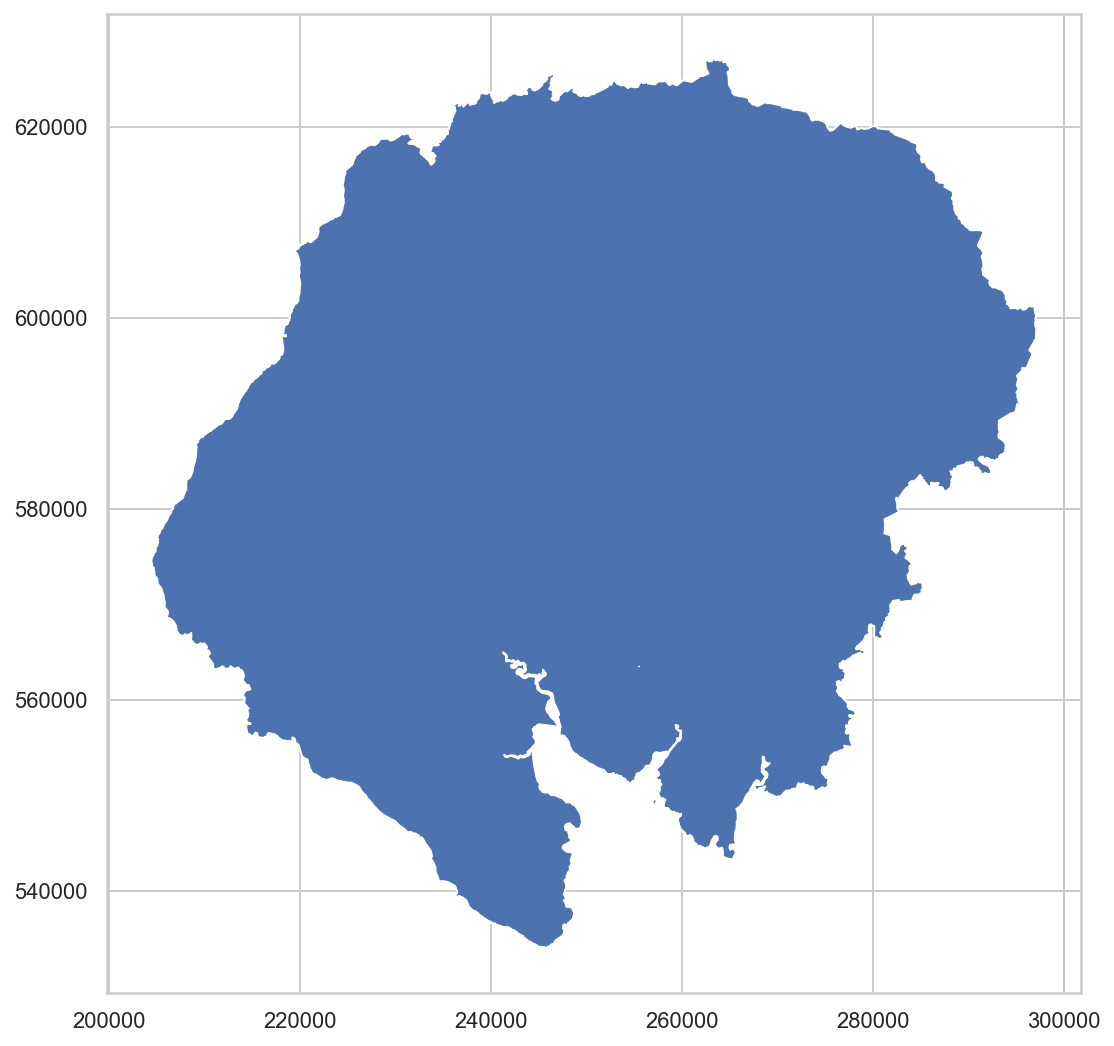

In [8]:
our_park_polygon = our_park.dissolve(by="NAME")
our_park_polygon.plot()

### Dataset 1: NFI woodland map 2018 
 
The NFI woodland map covers all forest and woodland area over 0.5 hectare with a minimum of 20% canopy cover (or the potential to achieve it) and a minimum width of 20 metres, including areas of new planting, clearfell, windblow and restocked areas.

**Category**             

1.            Woodland – areas greater than 0.5 hectares that represents the extent of mapped woodland

2.            Non woodland – open areas greater than 0.5 hectares completely surrounded by woodland



**Interpreted Forest Types (IFT) Woodland areas classification**

1.            Conifer - Coniferous woodland often occurs as large plantations with trees in regular rows and the stand edges may be regular and sharply defined. Some broadleaved trees may also be present but greater than 80% of the area will consist of conifers.

2.            Broadleaved - The canopy of broadleaved woodland is generally more uneven than that of coniferous woodland being made up of rounded crowns but with variations according to species, age, height, and season. Boundaries with adjacent internal polygons are generally less clearly defined than with conifers and naturally occurring stands may grade into adjacent ones with no sharp division. Some coniferous trees may be present but greater than 80% of the area will consist of broadleaved trees.

3.            Mixed Predominantly conifer - The interpretation of Mixed woodland can be very difficult as it exhibits intermediate characteristics between Conifer and Broadleaved woodland. There can be several types of mixed woodland. A plantation of alternate rows of conifer and broadleaves may produce a 'striped' appearance. You may see conifer and broadleaves planted in blocks, and there may be general intersperse woodland. The proportion of the Conifer will be more than 50% of the area and less than 80%.

4.            Mixed Predominantly broadleaved - The interpretation of Mixed woodland can be very difficult as it exhibits intermediate characteristics between Conifer and Broadleaved woodland. There can be several types of mixed woodland. A plantation of alternate rows of conifer and broadleaves may produce a 'striped' appearance. You may see conifer and broadleaves planted in blocks, and there may be general intersperse woodland. The proportion of the Broadleaves will be more than 50% of the area and less than 80%.

5.            Coppice - The most important characteristic of coppice areas on aerial photography is very even, smooth appearance. The coppice area may be made up of a patchwork of different ages (heights) but all show this very even character. Areas recently cut may appear to have a very clear floor with little felling debris.

6.            Coppice-with-Standards - Some areas of coppice also include larger broadleaved trees set in the coppice matrix. These broadleaved trees, often oak, are known as standards and show very clearly over the even coppice as large rounded crowns. The distribution of the standards may also be fairly scattered with approximately 25 per ha.

7.            Shrub - This category is intended to include areas that may possibly be woodland, where the growth is close to the ground and shows a rough character but no clear differentiation between Conifer and Broadleaved can yet be made. Areas being colonised by woody species may fall into this category. The cover will be at least 20%.

8.            Young Trees - Areas where planting is clearly visible but the trees cannot yet be allocated between Conifer and Broadleaved due to their immaturity. These areas can be on either land new to woodland or where a felled crop has been replaced.

9.            Felled - Areas of woodland where the trees have been harvested or felled. Stumps or felled trees may be visible and there may be long heaps of felling debris ('windrows'). Some standing trees within this limit may also be present but should be disregarded. The areas concerned may also have been re-stocked but the new trees are not yet visible.

10.          Ground Prepared for New Planting - Land in this category is area recently converted from some other land use to woodland and will show plough furrows or mounding but the new planting (if present) cannot yet be discerned

11.          Cloud or Shadow - If cloud or shadow areas obscure woodland detail and it is difficult to allocate one of the above IFTs, and then digitise a new boundary line feature around the area of uncertain forest type.

12.          Uncertain - Where the interpreter is uncertain of the IFT/IOA to be used X will be designated. The rate of use of this category should decline over time as operators become more proficient and better at recognising IFT/IOAs. As part of the QA procedures X's will be checked and operators found using this code frequently will be subject to more intensive QA procedures and possibly more training.

13.          Low density- This category intended to include areas that have less than 20% canopy cover that might have potential to achieve woodland in the future.  These areas will be monitored in future updates and either updated to reflect forest type or removed from the dataset.

14.          Assumed woodland - The supplied grant scheme and FC new planting polygons have been attributed as 'assumed woodland' as these areas have not been checked against the latest images and will be monitored in future updates and either updated to reflect forest type or removed from the dataset.

15.          Failed - Areas that show evidence of ground prep over several years and still exhibit no evidence of tress, based on the latest available imagery.

16.          Windblow - Areas of woodland where the trees have been uprooting or broken by the wind and which remain uncleared and not regenerated based on the latest available imagery.

**Non woodland areas classification**

1.            Open water - Normally labelled within OSMM, areas of even colour.

2.            Grass - A predominantly grassy area - may be agricultural or not.

3.            Agricultural land - May contain a cereal crop or pasture.

4.            Urban/Building - Buildings within woodland areas, may include gardens surrounding the building.

5.            Forest road, track - Linear feature, often fairly straight with gentle bends or turning circles.

6.            River - Linear feature, depending on location can be fairly straight or meander through woodland.

7.            Powerline - Possible shadow evidence of poles, pylons or even the cable/lines.

8.            Quarry - Show change in vegetation to geology, sand, slate, rock etc. Active quarries could have buildings, heavy plant tracks leading into the quarry.

9.            Bare - Bare ground/rock.

10.          Windfarm - Possible shadow evidence of turbines, normally in groups.

11.          Other vegetation - Not covered by the above, e.g. Gorse, Rhododendron, Bracken, Heather etc.


**Notes**

a.            Species such as Gorse and Rhododendron are not regarded as woodland and have therefore been excluded.

b.            Orchards are not regarded as woodland but have been mapped for carbon accounting purposes. Details can be provided on request.

c.             Interpreted Forest Types are only used to classify polygons in the NFI digital woodland map. IFTs are useful when using the map without the sample data, and for smaller geographic areas where the sample data would be inappropriate. However, for larger geographic areas data on forest types collected in the field is considered to be more accurate, and hence is used for reporting purposes.

In [9]:
nfi_fpath = os.path.join(data_raw, "National_Forest_Inventory_Woodland_Scotland_2018", "7ee62919-7aa2-471a-8dc8-27204598d3e62020329-1-6cjzao.spys6.shp")
nfi = gpd.read_file(nfi_fpath)

In [10]:
nfi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 202780 entries, 0 to 202779
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   OBJECTID_1  202780 non-null  int64   
 1   OBJECTID    202780 non-null  int64   
 2   CATEGORY    202780 non-null  object  
 3   IFT_IOA     202780 non-null  object  
 4   COUNTRY     202780 non-null  object  
 5   Shape_Leng  202780 non-null  float64 
 6   Area_ha     202780 non-null  float64 
 7   Shape__Are  202780 non-null  float64 
 8   Shape__Len  202780 non-null  float64 
 9   geometry    202780 non-null  geometry
dtypes: float64(4), geometry(1), int64(2), object(3)
memory usage: 15.5+ MB


In [11]:
%%capture
nfi_valid = nfi.loc[nfi.is_valid]

INFO:shapely.geos:Ring Self-intersection at or near point 254932.511 758402.49800000002
INFO:shapely.geos:Ring Self-intersection at or near point 315868.5 611941
INFO:shapely.geos:Ring Self-intersection at or near point 308560.28999999998 634322.34999999998
INFO:shapely.geos:Ring Self-intersection at or near point 255454.41 706364.97000000102
INFO:shapely.geos:Ring Self-intersection at or near point 281574.53499999997 720473.25100000005
INFO:shapely.geos:Ring Self-intersection at or near point 182285.35500000001 759029.97100000095
INFO:shapely.geos:Ring Self-intersection at or near point 308222.288 793170.01700000104
INFO:shapely.geos:Ring Self-intersection at or near point 269329.26299999998 795103.47900000005
INFO:shapely.geos:Ring Self-intersection at or near point 277801.32299999997 798030.29599999997
INFO:shapely.geos:Ring Self-intersection at or near point 360806.07299999997 833108.75699999905
INFO:shapely.geos:Ring Self-intersection at or near point 220631.51000000001 852039.579

In [12]:
nfi_valid_clipped = gpd.clip(nfi_valid, our_park_polygon.convex_hull.envelope)
nfi_valid_clipped

,OBJECTID_1,OBJECTID,CATEGORY,IFT_IOA,COUNTRY,Shape_Leng,Area_ha,Shape__Are,Shape__Len,geometry
1,2,883,Non woodland,Bare area,Scotland,1053.621578,3.357781,3.357781e+04,1053.621578,"POLYGON ((233732.700 549963.900, 233733.001 54..."
2,3,884,Non woodland,Bare area,Scotland,355.234345,0.666762,6.667620e+03,355.234345,"POLYGON ((276166.271 552164.696, 276154.718 55..."
3,4,885,Non woodland,Bare area,Scotland,498.972486,0.758013,7.580132e+03,498.972486,"POLYGON ((275930.599 552437.627, 275943.884 55..."
4,5,886,Non woodland,Bare area,Scotland,546.104475,1.012414,1.012414e+04,546.104475,"POLYGON ((275640.360 552722.940, 275674.840 55..."
5,6,887,Non woodland,Bare area,Scotland,380.274117,0.831665,8.316648e+03,380.274117,"POLYGON ((235164.270 553569.222, 235170.598 55..."
...,...,...,...,...,...,...,...,...,...,...
198827,198828,608919,Woodland,Windblow,Scotland,458.046995,1.059733,1.059733e+04,458.046995,"POLYGON ((277596.771 626770.099, 277561.052 62..."
198828,198829,608920,Woodland,Windblow,Scotland,444.613416,1.061602,1.061602e+04,444.613416,"POLYGON ((277456.841 626896.597, 277441.902 62..."
202766,202767,613185,Woodland,Conifer,Scotland,82249.064441,1048.792329,1.048792e+07,82249.064441,"POLYGON ((240927.530 576750.219, 240927.377 57..."
202776,202777,613216,Woodland,Windblow,Scotland,1104.512784,3.614690,3.614690e+04,1104.512784,"POLYGON ((241140.500 573257.500, 241137.638 57..."


#### Save for time reasons

In [13]:
nfi_outpath = os.path.join(data_processed, "NFI_valid_and_clipped.shp")

if not os.path.exists(nfi_outpath):
    nfi_valid_clipped.to_file(nfi_outpath)

In [35]:
nfi_valid_clipped.IFT_IOA.unique()

array(['Bare area', 'Agriculture land', 'Urban', 'Grassland', 'Quarry',
       'Road', 'Other vegetation', 'River', 'Open water', 'Windfarm',
       'Assumed woodland', 'Broadleaved', 'Conifer', 'Felled', 'Failed',
       'Ground prep', 'Low density', 'Mixed mainly broadleaved',
       'Mixed mainly conifer', 'Young trees', 'Coppice with standards',
       'Shrub', 'Windblow'], dtype=object)

#### Create mapping for NFI data

In [40]:
nfi_mapping = {}

keys = nfi_valid_clipped.IFT_IOA.unique()
values = np.arange(1, len(keys) + 1, 1)

for k, v in zip(keys, values):
    nfi_mapping[k] = v
    
nfi_mapping

{'Bare area': 1,
 'Agriculture land': 2,
 'Urban': 3,
 'Grassland': 4,
 'Quarry': 5,
 'Road': 6,
 'Other vegetation': 7,
 'River': 8,
 'Open water': 9,
 'Windfarm': 10,
 'Assumed woodland': 11,
 'Broadleaved': 12,
 'Conifer': 13,
 'Felled': 14,
 'Failed': 15,
 'Ground prep': 16,
 'Low density': 17,
 'Mixed mainly broadleaved': 18,
 'Mixed mainly conifer': 19,
 'Young trees': 20,
 'Coppice with standards': 21,
 'Shrub': 22,
 'Windblow': 23}

**Colormaps:** https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

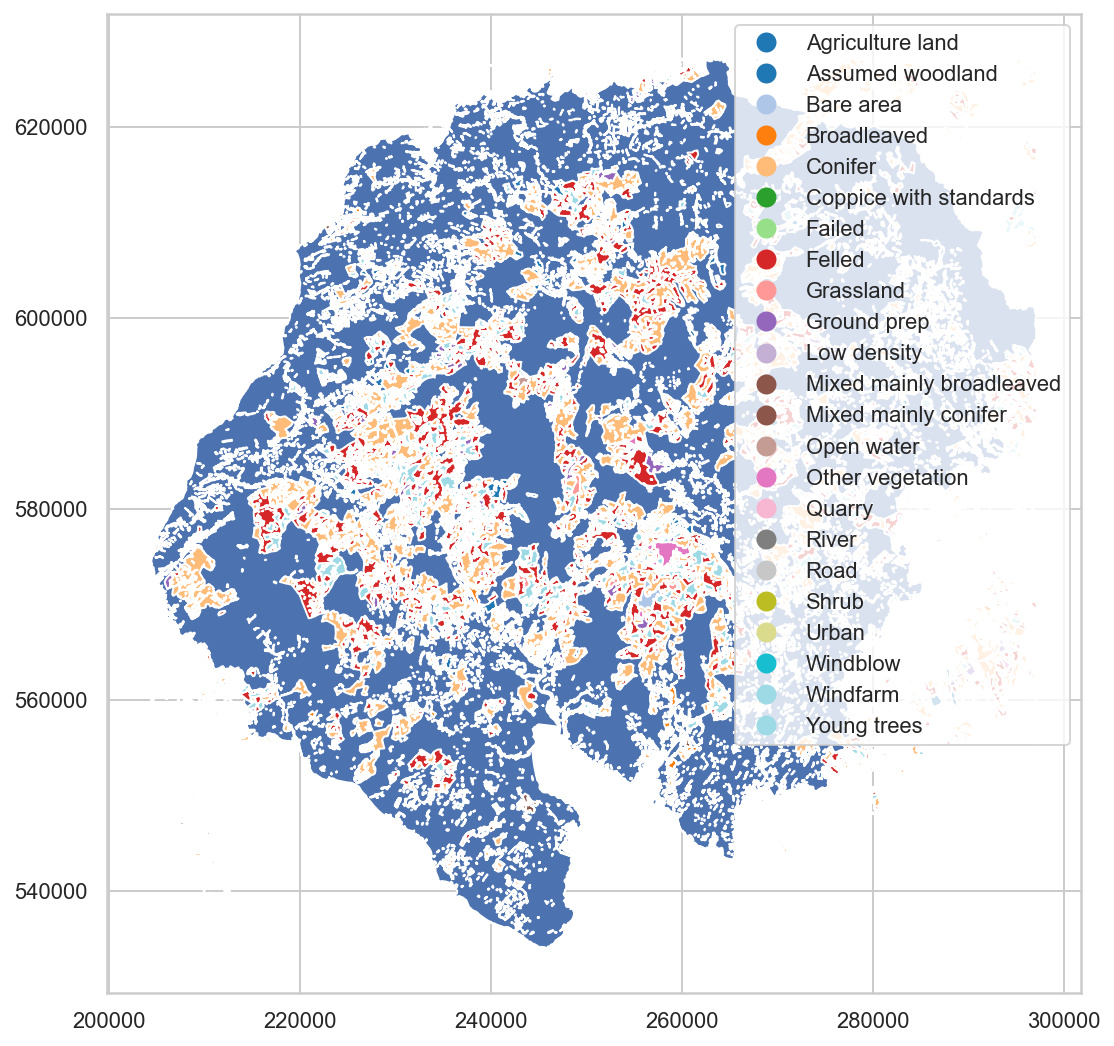

In [41]:
# biosphere backdrop
ax = our_park_polygon.plot()

# nfi plot
nfi_valid_clipped.plot(
    column = "IFT_IOA",
    legend = True,
    cmap = "tab20",
    ax=ax
)

# save
plt.savefig(
    os.path.join(figure_dir, "nfi_map_clipped_to_biosphere.png"),
    dpi=150,
    format="png"
)

### Dataset 2: Historic Land-use Assessment project (HLA)
The Historic Land-use Assessment project (HLA) is digitally recording land use across Scotland. It maps both activities like industrial farming or ski areas that are current today, and also land use activities from periods in the past, such as charcoal burning or prehistoric agriculture and settlement. The data has been gathered since 1997 as a partnership between Historic Scotland (HS) and the Royal Commision on the Ancient and Historical Monuments of Scotland and coverage was completed in 2015, a  year that also saw the merging of the two organisations into Historic Environment Scotland.

In [16]:
lulc_fpath = os.path.join(data_raw, "HLAmap", "HLA_Dec2017.shp")
lulc = gpd.read_file(lulc_fpath)

In [17]:
lulc.Period.unique()

array(['None', '18th Century-Present', '18th-19th Century',
       '19th Century-Present', '20th Century-Present',
       'Late 20th Century-Present', '17th-20th Century',
       '18th-20th Century', '19th-20th Century', '20th Century',
       'Medieval/Post-medieval', 'Medieval'], dtype=object)

In [18]:
lulc.Historic_L.unique()

array(['Water Body', 'Agriculture and Settlement', 'Rural Settlement',
       'Built-up Area', 'Woodland and Forestry', 'Leisure and Recreation',
       'Designed Landscape', 'Transport', 'Defence',
       'Energy, Extraction and Waste', 'Spiritual and Ritual',
       'Moorland and Rough Grazing'], dtype=object)

In [19]:
lulc.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°45'N to 61°N, 9°W to 2°E
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [20]:
if run_time_intensive_task:
    lulc.plot(column="Type")

In [21]:
parks.crs == lulc.crs

True

#### Decision on timestamp of land-use categories based on https://hlamap.org.uk/pdfs/HLA%20Glossary.pdf

In [22]:
%%capture
lulc_modern = lulc.loc[lulc.Period == "Late 20th Century-Present"]
lulc_modern_valid = lulc_modern.loc[lulc_modern.is_valid]

INFO:shapely.geos:Ring Self-intersection at or near point 268444.75 669433.91000000015
INFO:shapely.geos:Ring Self-intersection at or near point 277931.93580000009 767368.69629999995
INFO:shapely.geos:Ring Self-intersection at or near point 293872.78120000008 695773.5
INFO:shapely.geos:Ring Self-intersection at or near point 320919.17379999999 696969.01080000028
INFO:shapely.geos:Ring Self-intersection at or near point 224946.43200000003 573504.24300000072
INFO:shapely.geos:Ring Self-intersection at or near point 265948.0175999999 543457.49620000087
INFO:shapely.geos:Ring Self-intersection at or near point 255693.82749999966 564711.53879999928
INFO:shapely.geos:Ring Self-intersection at or near point 327469.6875 577177.81230000034
INFO:shapely.geos:Ring Self-intersection at or near point 260657.15529999975 578437.16019999981
INFO:shapely.geos:Ring Self-intersection at or near point 232157.66509999987 576125.15780000016
INFO:shapely.geos:Ring Self-intersection at or near point 229772.03

In [23]:
park_modern_lulc = gpd.clip(lulc_modern_valid, our_park_polygon.convex_hull.envelope)

In [24]:
park_modern_lulc.columns

Index(['TAG', 'HIS_CODE', 'REL1_CODE', 'REL2_CODE', 'REL3_CODE', 'Historic_L',
       'Period', 'Type', 'Code', 'Rel1_Cat', 'Rel1_Per', 'Rel1_Typ',
       'Rel1_Code_', 'Rel2_Cat', 'Rel2_Per', 'Rel2_Typ', 'Rel2_Code_',
       'Rel3_Cat', 'Rel3_Per', 'Rel3_Typ', 'Rel3_Code_', 'SHAPE_Leng',
       'SHAPE_Area', 'geometry'],
      dtype='object')

#### Plot HLA within our area

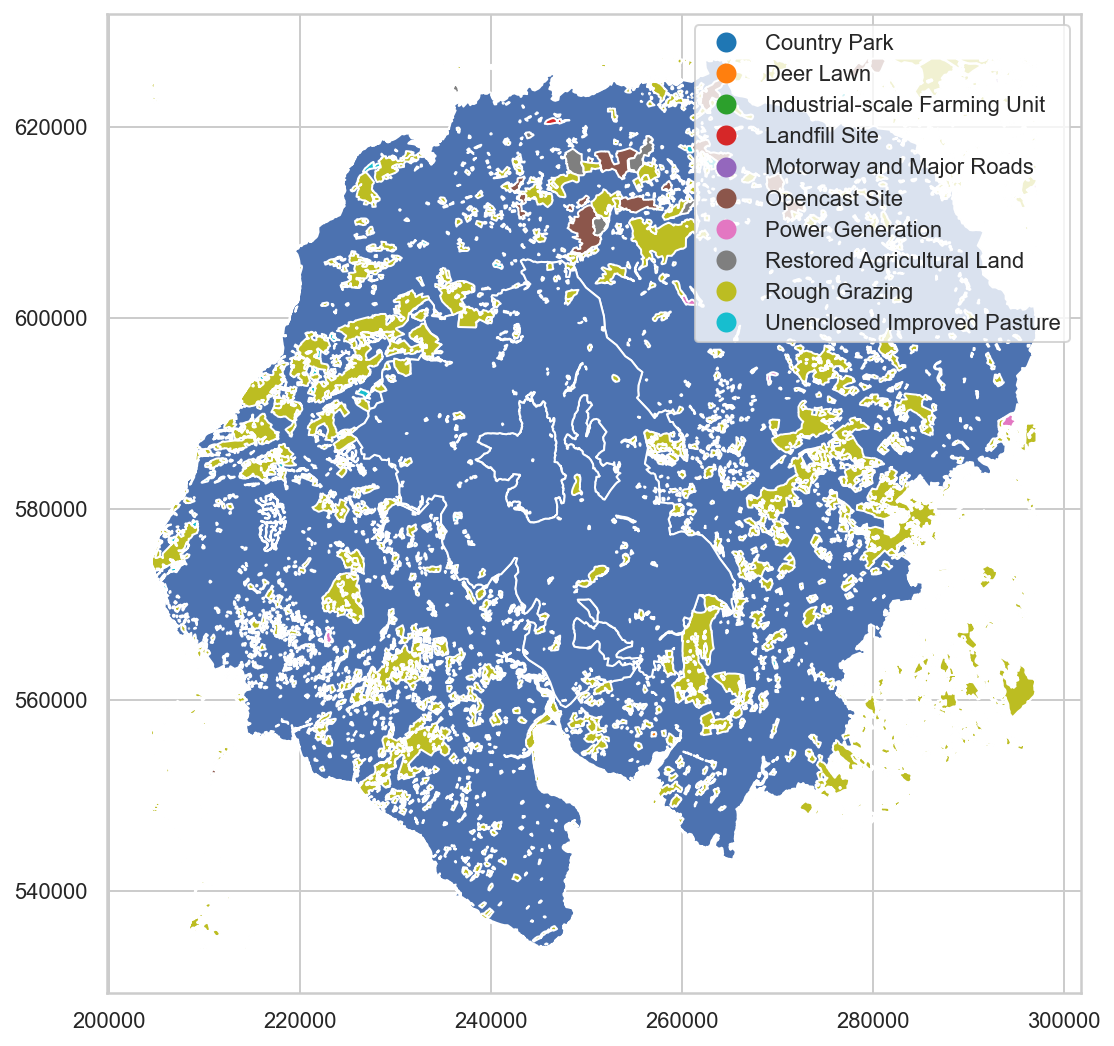

In [25]:
ax = our_park.plot()
park_modern_lulc.plot(
    column = "Type",
    legend = True,
    ax=ax
)

plt.savefig(
    os.path.join(figure_dir, "original_map_forest_missing.png"),
    dpi=150,
    format="png"
)

In [26]:
park_modern_lulc.Type.unique()

array(['Country Park', 'Motorway and Major Roads', 'Landfill Site',
       'Opencast Site', 'Industrial-scale Farming Unit',
       'Restored Agricultural Land', 'Unenclosed Improved Pasture',
       'Deer Lawn', 'Power Generation', 'Rough Grazing'], dtype=object)

In [27]:
park_modern_lulc["lulc_type_num"] = 255

#### Define mapping of land use categories

In [28]:
mapping = {
    'Country Park': 1,
    'Motorway and Major Roads': 2,
    'Landfill Site': 3,
    'Opencast Site': 4,
    'Industrial-scale Farming Unit': 5,
    'Restored Agricultural Land': 6,
    'Unenclosed Improved Pasture': 7,
    'Deer Lawn': 8,
    'Power Generation': 9,
    'Rough Grazing': 10
}

In [29]:
park_modern_lulc["lulc_type_num"] = [mapping[k] for k in park_modern_lulc.Type.values]
park_modern_lulc["lulc_type_num"] = park_modern_lulc.lulc_type_num.astype("int16")

#### 1) Convert HLA polygon's to raster (key piece of code)
Based on https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html

In [30]:
park_modern_lulc.is_valid.value_counts()

True    4387
dtype: int64

array([[   2,    7],
       [   3,    5],
       [   4,   54],
       [   5,   17],
       [   6,   22],
       [   7,   25],
       [   8,    1],
       [   9,   37],
       [  10, 3710],
       [ 255, 4222]])


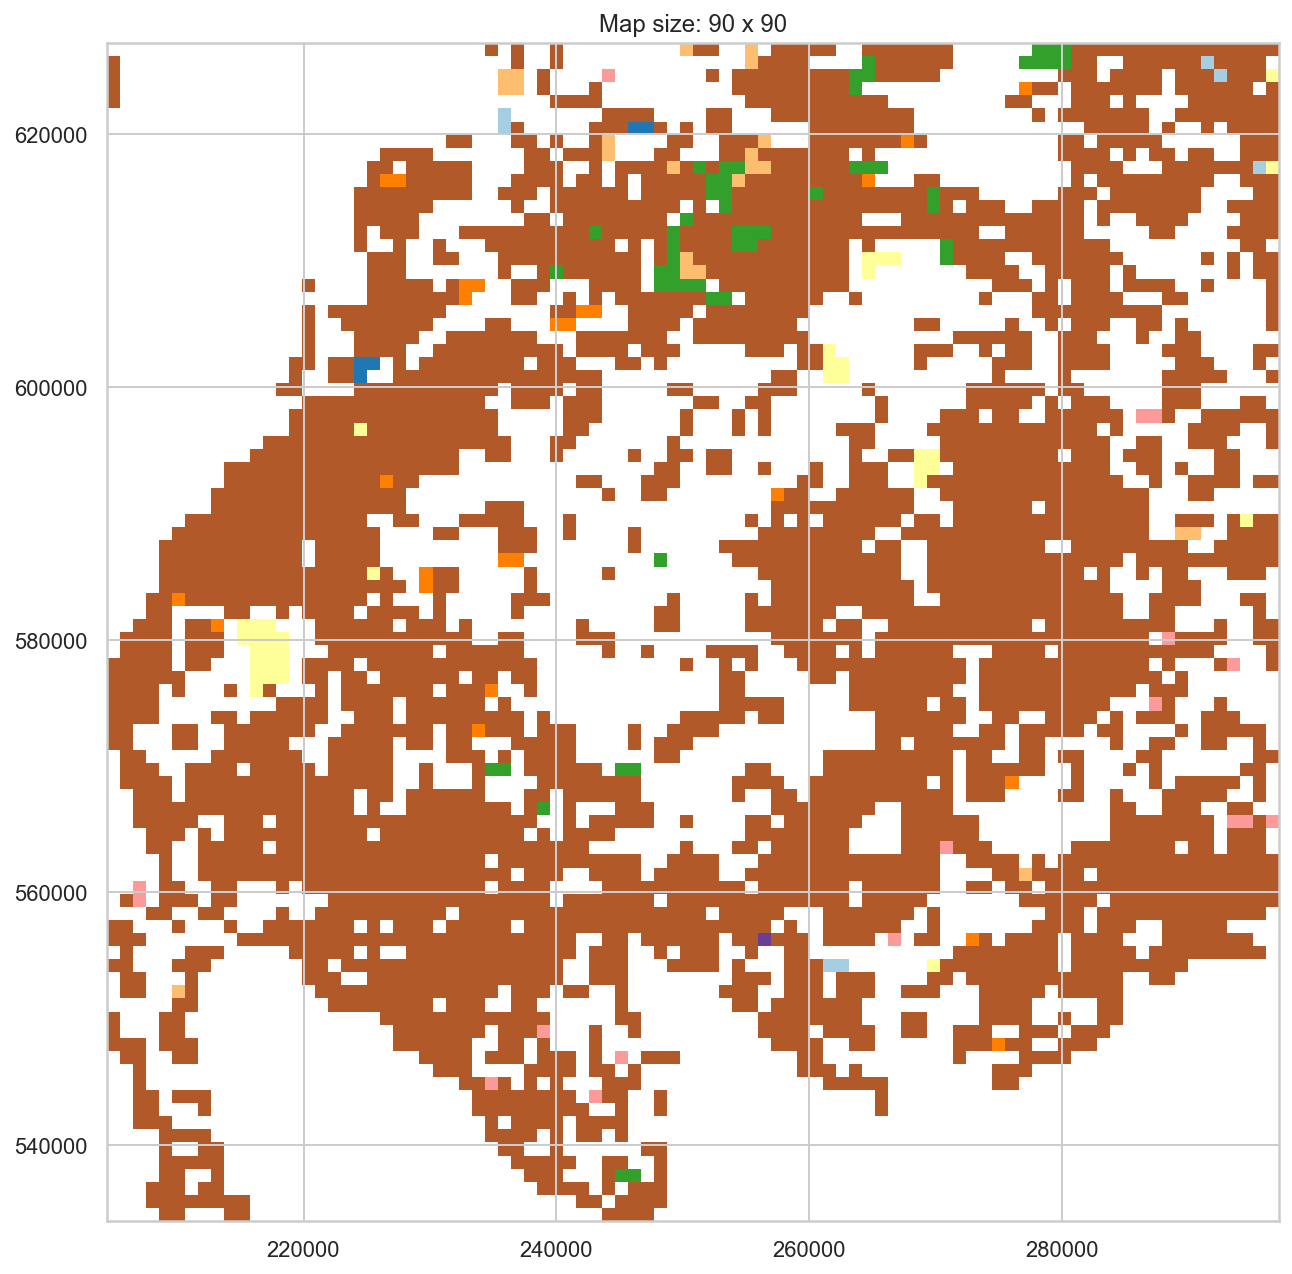

In [31]:
import rasterio
from pprint import pprint
from rasterio import features
from rasterio.plot import show

# 1) set bounds
bounds = our_park_polygon.convex_hull.envelope.bounds

# 2) define transform
coordinate_transform = rasterio.transform.from_bounds(
    west = bounds.minx.values[0], 
    south = bounds.miny.values[0], 
    east = bounds.maxx.values[0], 
    north = bounds.maxy.values[0], 
    width = cols, 
    height = rows
)

# 3) define path of output raster data
raster_fpath = os.path.join(data_processed, 'HLA_rasterized_{}_{}.tif'.format(rows, cols))

# 4) run burn-in algorithm
with rasterio.Env():
    
    # create array of (shape, value) tuples
    shapes = [(geom,value) for geom, value in zip(park_modern_lulc.geometry, park_modern_lulc.lulc_type_num)]
    
    # rasterize
    burned = features.rasterize(
        shapes=shapes, 
        out_shape=(rows, cols), 
        fill=255, 
        transform=coordinate_transform,
        all_touched=True
    )
    
    # value counts
    unique, counts = np.unique(burned, return_counts=True)
    pprint(np.asarray((unique, counts)).T)
    
    # count bands
    band_count = len(unique)
    
    # save as geotiff
    with rasterio.open(
            raster_fpath,
            'w+', # Open the file in read/write mode
            driver='GTiff',
            width=cols,
            height=rows,
            count=1,
            dtype=rasterio.uint8,
            nodata=255,
            transform=coordinate_transform,
            compress='lzw',
            crs={'init': "EPSG:4326"}) as out:
        
        # write bands
        out.write(burned.astype(rasterio.uint8), indexes=1)

# 5) re-read the saved geotiff as a test and read the first layer of the map
src = rasterio.open(raster_fpath)
game_map = src.read(1, masked=True)

# 6) create a plot of the resulting map
fig, ax = plt.subplots()
show(game_map, ax=ax, transform=src.transform, cmap="Paired")

ax.set_title("Map size: {} x {}".format(rows, cols))
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "map_{}_{}.png".format(rows, cols)),
    dpi=150,
    format="png"
)

#### 2) Convert NFI polygon's to raster (key piece of code)
Based on https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html

In [36]:
nfi_valid_clipped

,OBJECTID_1,OBJECTID,CATEGORY,IFT_IOA,COUNTRY,Shape_Leng,Area_ha,Shape__Are,Shape__Len,geometry
1,2,883,Non woodland,Bare area,Scotland,1053.621578,3.357781,3.357781e+04,1053.621578,"POLYGON ((233732.700 549963.900, 233733.001 54..."
2,3,884,Non woodland,Bare area,Scotland,355.234345,0.666762,6.667620e+03,355.234345,"POLYGON ((276166.271 552164.696, 276154.718 55..."
3,4,885,Non woodland,Bare area,Scotland,498.972486,0.758013,7.580132e+03,498.972486,"POLYGON ((275930.599 552437.627, 275943.884 55..."
4,5,886,Non woodland,Bare area,Scotland,546.104475,1.012414,1.012414e+04,546.104475,"POLYGON ((275640.360 552722.940, 275674.840 55..."
5,6,887,Non woodland,Bare area,Scotland,380.274117,0.831665,8.316648e+03,380.274117,"POLYGON ((235164.270 553569.222, 235170.598 55..."
...,...,...,...,...,...,...,...,...,...,...
198827,198828,608919,Woodland,Windblow,Scotland,458.046995,1.059733,1.059733e+04,458.046995,"POLYGON ((277596.771 626770.099, 277561.052 62..."
198828,198829,608920,Woodland,Windblow,Scotland,444.613416,1.061602,1.061602e+04,444.613416,"POLYGON ((277456.841 626896.597, 277441.902 62..."
202766,202767,613185,Woodland,Conifer,Scotland,82249.064441,1048.792329,1.048792e+07,82249.064441,"POLYGON ((240927.530 576750.219, 240927.377 57..."
202776,202777,613216,Woodland,Windblow,Scotland,1104.512784,3.614690,3.614690e+04,1104.512784,"POLYGON ((241140.500 573257.500, 241137.638 57..."


In [39]:
nfi_mapping

{'Bare area': 1,
 'Agriculture land': 2,
 'Urban': 3,
 'Grassland': 4,
 'Quarry': 5,
 'Road': 6,
 'Other vegetation': 7,
 'River': 8,
 'Open water': 9,
 'Windfarm': 10,
 'Assumed woodland': 11,
 'Broadleaved': 12,
 'Conifer': 13,
 'Felled': 14,
 'Failed': 15,
 'Ground prep': 16,
 'Low density': 17,
 'Mixed mainly broadleaved': 18,
 'Mixed mainly conifer': 19,
 'Young trees': 20,
 'Coppice with standards': 21,
 'Shrub': 22}

In [44]:
nfi_valid_clipped["IFT_IOA_num"] = [nfi_mapping[k] for k in nfi_valid_clipped.IFT_IOA.values]
nfi_valid_clipped["IFT_IOA_num"] = nfi_valid_clipped.IFT_IOA_num.astype("int16")

In [ ]:
nfi_valid_clipped = nfi_valid_clipped.infer_objects()

In [ ]:
rows = cols = 40

# 0) define geodataframe
gdf = nfi_valid_clipped

# 1) set bounds
bounds = our_park_polygon.convex_hull.envelope.bounds

# 2) define transform
coordinate_transform = rasterio.transform.from_bounds(
    west = bounds.minx.values[0], 
    south = bounds.miny.values[0], 
    east = bounds.maxx.values[0], 
    north = bounds.maxy.values[0], 
    width = cols, 
    height = rows
)

# 3) define path of output raster data
raster_fpath = os.path.join(data_processed, 'NFI_rasterized_{}_{}.tif'.format(rows, cols))

# 4) run burn-in algorithm
with rasterio.Env():
    
    # create array of (shape, value) tuples
    shapes = [(geom,value) for geom, value in zip(gdf.geometry.values, gdf.IFT_IOA_num.values)]
    
    # rasterize
    burned = features.rasterize(
        shapes=shapes, 
        out_shape=(rows, cols), 
        fill=255, 
        transform=coordinate_transform,
        all_touched=True
    )
    
    # value counts
    unique, counts = np.unique(burned, return_counts=True)
    pprint(np.asarray((unique, counts)).T)
    
    # count bands
    band_count = len(unique)
    
    # save as geotiff
    with rasterio.open(
            raster_fpath,
            'w+', # Open the file in read/write mode
            driver='GTiff',
            width=cols,
            height=rows,
            count=1,
            dtype=rasterio.uint8,
            nodata=255,
            transform=coordinate_transform,
            compress='lzw',
            crs={'init': "EPSG:4326"}) as out:
        
        # write bands
        out.write(burned.astype(rasterio.uint8), indexes=1)

# 5) re-read the saved geotiff as a test and read the first layer of the map
src = rasterio.open(raster_fpath)
game_map = src.read(1, masked=True)

# 6) create a plot of the resulting map
fig, ax = plt.subplots()
show(game_map, ax=ax, transform=src.transform, cmap="Paired")

ax.set_title("Map size: {} x {}".format(rows, cols))
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "NFI_map_{}_{}.png".format(rows, cols)),
    dpi=150,
    format="png"
)

In [51]:
rows = cols = 40

# 0) define geodataframe
gdf = nfi_valid_clipped

# 1) set bounds
bounds = our_park_polygon.convex_hull.envelope.bounds

# 2) define transform
coordinate_transform = rasterio.transform.from_bounds(
    west = bounds.minx.values[0], 
    south = bounds.miny.values[0], 
    east = bounds.maxx.values[0], 
    north = bounds.maxy.values[0], 
    width = cols, 
    height = rows
)

# 3) define path of output raster data
raster_fpath = os.path.join(data_processed, 'NFI_rasterized_{}_{}.tif'.format(rows, cols))

# 4) run burn-in algorithm
with rasterio.Env():
    
    # create array of (shape, value) tuples
    shapes = [(geom,value) for geom, value in zip(gdf.geometry.values, gdf.IFT_IOA_num.values)]
    
    # rasterize
    burned = features.rasterize(
        shapes=shapes, 
        out_shape=(rows, cols), 
        fill=255, 
        transform=coordinate_transform,
        all_touched=True
    )
    
    # value counts
    unique, counts = np.unique(burned, return_counts=True)
    pprint(np.asarray((unique, counts)).T)
    
    # count bands
    band_count = len(unique)
    
    # save as geotiff
    with rasterio.open(
            raster_fpath,
            'w+', # Open the file in read/write mode
            driver='GTiff',
            width=cols,
            height=rows,
            count=1,
            dtype=rasterio.uint8,
            nodata=255,
            transform=coordinate_transform,
            compress='lzw',
            crs={'init': "EPSG:4326"}) as out:
        
        # write bands
        out.write(burned.astype(rasterio.uint8), indexes=1)

# 5) re-read the saved geotiff as a test and read the first layer of the map
src = rasterio.open(raster_fpath)
game_map = src.read(1, masked=True)

# 6) create a plot of the resulting map
fig, ax = plt.subplots()
show(game_map, ax=ax, transform=src.transform, cmap="Paired")

ax.set_title("Map size: {} x {}".format(rows, cols))
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "NFI_map_{}_{}.png".format(rows, cols)),
    dpi=150,
    format="png"
)

array([[ 11,   4],
       [ 12,  29],
       [ 13,  50],
       [ 14,  45],
       [ 15,   3],
       [ 16,  13],
       [ 17,   4],
       [ 18,  46],
       [ 19,  72],
       [ 20, 431],
       [ 22, 248],
       [ 23, 270],
       [255, 385]])


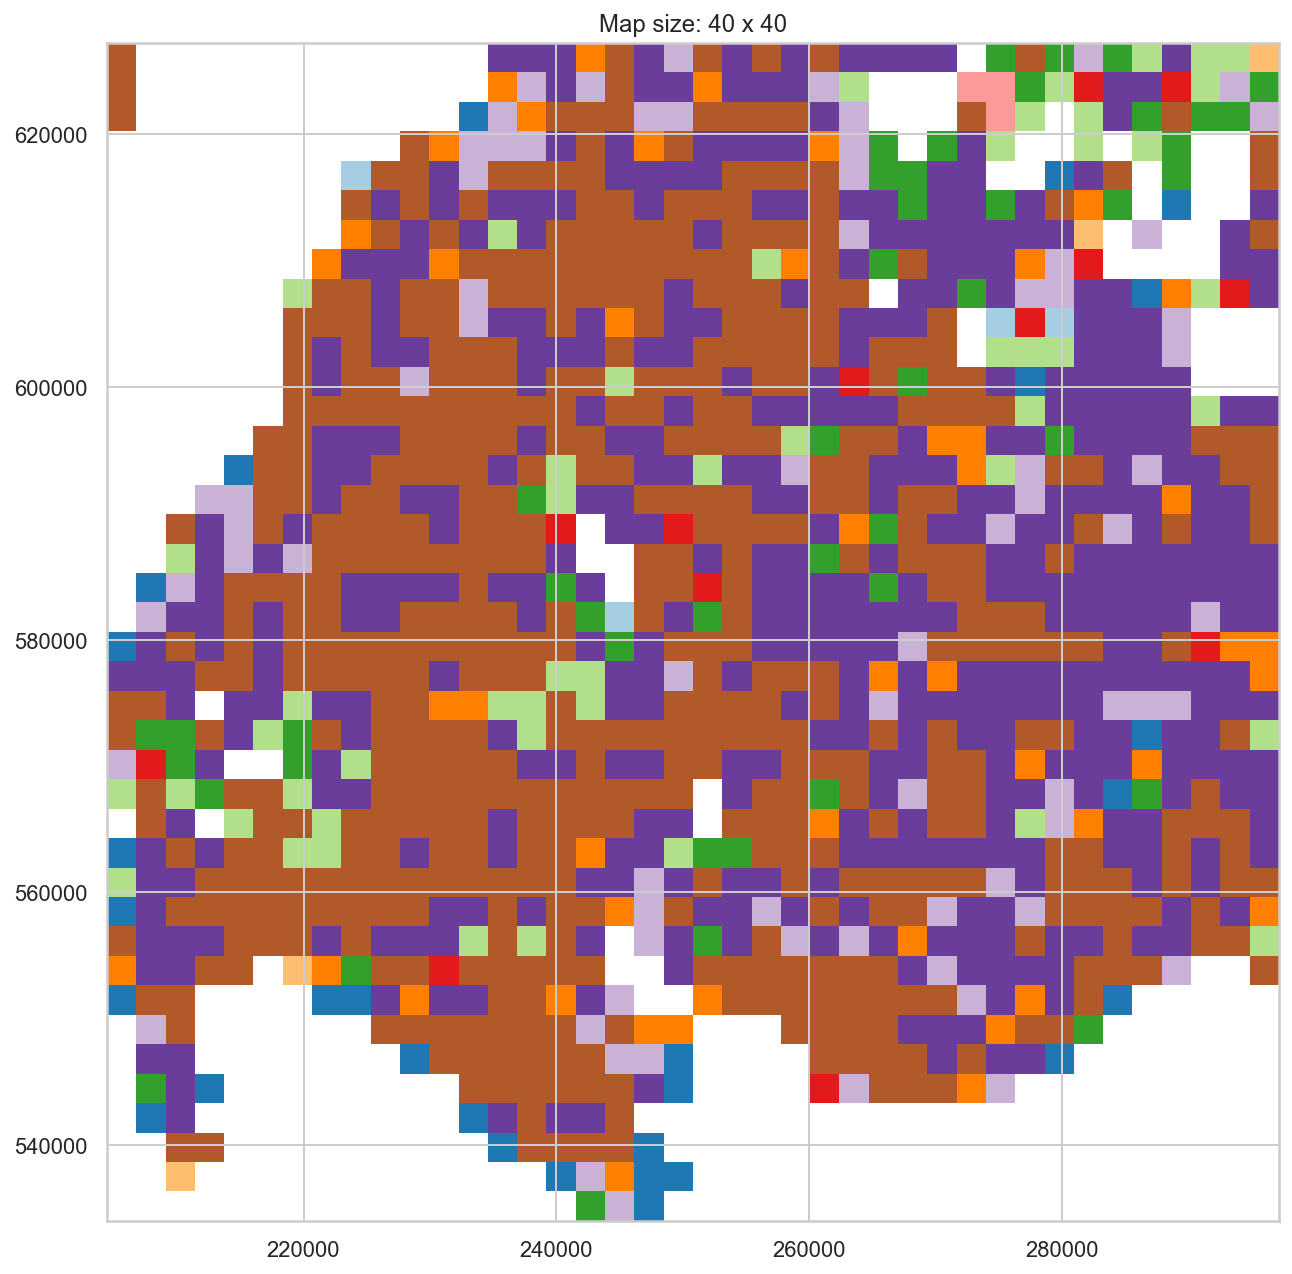

In [59]:
rows = cols = 40

# 0) define geodataframe
gdf = nfi_valid_clipped

# 1) set bounds
bounds = our_park_polygon.convex_hull.envelope.bounds

# 2) define transform
coordinate_transform = rasterio.transform.from_bounds(
    west = bounds.minx.values[0], 
    south = bounds.miny.values[0], 
    east = bounds.maxx.values[0], 
    north = bounds.maxy.values[0], 
    width = cols, 
    height = rows
)

# 3) define path of output raster data
raster_fpath = os.path.join(data_processed, 'NFI_rasterized_{}_{}.tif'.format(rows, cols))

# 4) run burn-in algorithm
with rasterio.Env():
    
    # create array of (shape, value) tuples
    shapes = [(geom,value) for geom, value in zip(gdf.geometry.values, gdf.IFT_IOA_num.values)]
    
    # rasterize
    burned = features.rasterize(
        shapes=shapes, 
        out_shape=(rows, cols), 
        fill=255, 
        transform=coordinate_transform,
        all_touched=True
    )
    
    # value counts
    unique, counts = np.unique(burned, return_counts=True)
    pprint(np.asarray((unique, counts)).T)
    
    # count bands
    band_count = len(unique)
    
    # save as geotiff
    with rasterio.open(
            raster_fpath,
            'w+', # Open the file in read/write mode
            driver='GTiff',
            width=cols,
            height=rows,
            count=1,
            dtype=rasterio.uint8,
            nodata=255,
            transform=coordinate_transform,
            compress='lzw',
            crs={'init': "EPSG:4326"}) as out:
        
        # write bands
        out.write(burned.astype(rasterio.uint8), indexes=1)

# 5) re-read the saved geotiff as a test and read the first layer of the map
src = rasterio.open(raster_fpath)
game_map = src.read(1, masked=True)

# 6) create a plot of the resulting map
fig, ax = plt.subplots()
show(game_map, ax=ax, transform=src.transform, cmap="Paired")

ax.set_title("Map size: {} x {}".format(rows, cols))
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "NFI_map_{}_{}.png".format(rows, cols)),
    dpi=150,
    format="png"
)